In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import json
import os
import pickle
import sys

from konlpy.tag import Kkma, Okt
import gc

import re
from sklearn.feature_extraction.text import CountVectorizer

from collections import defaultdict

from ksenticnet_kaist import *

ksenticnet = get_ksenticnet()

keys = list(ksenticnet.keys())
senticvals = [[float(i) for i in val[:4]] for val in  ksenticnet.values()]
sentiments = []
polarity = []
semantics = []
for key, val in ksenticnet.items():
    for i in val[4:]:
        if i in ['positive', 'negative']:
            polar_ind = val.index(i)
            sentiments.append(val[4 : polar_ind])
            polarity.append(val[polar_ind : polar_ind+2])
            semantics.append(val[polar_ind+2 :])
            break

ksenticnets = defaultdict(dict)
for key, val, senti, p, seman in zip(keys, 
                                     senticvals, 
                                     sentiments, 
                                     polarity, 
                                     semantics):
    ksenticnets[key]['sentic_value'] = val
    ksenticnets[key]['sentiment'] = senti
    ksenticnets[key]['polarity'] = p
    ksenticnets[key]['semantic'] = seman

f = lambda x : [i if i > 0 else 0 for i in x]
g = lambda x : [abs(i) if i < 0 else 0 for i in x]
scores = np.array(list(map(lambda x : f(x) + g(x), senticvals)))
scores /= scores.sum(axis=1).reshape(-1, 1)

class KSenticNet():
    keys = {j : i for i, j in  enumerate(keys)}
    scores = scores
    
MAX_VOCAB_SIZE = 50000

def sampleFromDirichlet(alpha):
    return np.random.dirichlet(alpha)

def sampleFromCategorical(theta):
    theta = theta / np.sum(theta)
    return np.random.multinomial(1, theta).argmax()

def word_indices(wordOccurenceVec):
    for idx in wordOccurenceVec.nonzero()[0]:
        for i in range(int(wordOccurenceVec[idx])):
            yield idx
            
class KSenticNet():
    keys = {j : i for i, j in  enumerate(keys)}
    scores = scores
    
class SentimentLDAGibbsSampler:
    
    def __init__(self, numTopics, alpha, beta, gamma, numSentiments=2):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.numTopics = numTopics
        self.numSentiments = numSentiments
        
    def processSingleReview(self, review, st, d=None, stopwords=None):
        letters_only = re.sub('[^ㄱ-하-ㅣ가-힣]', ' ', review).strip()
        if not stopwords:
            stops = list('의가이은을로들는좀잘걍과도를자에와한것') + ['으로', '하다']
        else:
            stops = stopwords
        words = st.morphs(letters_only, stem=True, norm=True)
        meaningful_words = [w for w in words if w not in stops]
        return ' '.join(meaningful_words)
    
    def processReviews(self, reviews, st, saveAs=None, saveOverride=False, 
                       do_preprocess=True, return_processed_review=False):
        import os
        import dill
        if not saveOverride and saveAs and os.path.isfile(saveAs):
            [wordOccurenceMatrix, self.vectorizer] = dill.load(open(saveAs, 'r'))
            return wordOccurenceMatrix
        if do_preprocess:
            processed_reviews = []
            for i, review in enumerate(reviews):
                if (i + 1) % 10000 == 0:
                    print(' Review {} of {}'.format(i + 1, len(reviews)))
                processed_reviews.append(self.processSingleReview(review, st, i))
        else:
            processed_reviews = reviews
        if return_processed_review:
            return processed_reviews
        self.vectorizer = CountVectorizer(analyzer='word',
                                          tokenizer=None,
                                          preprocessor=None,
                                          max_features=MAX_VOCAB_SIZE)
        train_data_features = self.vectorizer.fit_transform(processed_reviews)
        wordOccurenceMatrix = train_data_features
        if saveAs:
            dill.dump([wordOccurenceMatrix, self.vectorizer], open(saveAs, 'w'))
        return wordOccurenceMatrix
    
    def _initialize_(self, reviews, st, saveAs=None, saveOverride=False, do_preprocess=True):
        self.wordOccurenceMatrix = self.processReviews(reviews, st, saveAs, saveOverride, do_preprocess)
        numDocs, vocabSize = self.wordOccurenceMatrix.shape
        
        # Pseudocounts
        self.n_dt = np.zeros((numDocs, self.numTopics))
        self.n_dts = np.zeros((numDocs, self.numTopics, self.numSentiments))
        self.n_d = np.zeros((numDocs))
        self.n_vts = np.zeros((vocabSize, self.numTopics, self.numSentiments))
        self.n_ts = np.zeros((self.numTopics, self.numSentiments))
        self.topics = {}
        self.sentiments = {}
        self.priorSentiment = {}
        
        alphaVec = self.alpha * np.ones(self.numTopics)
        gammaVec = self.gamma * np.ones(self.numSentiments)
        
        print('--* KSenticNet으로 사전 확률 조작 중... *--')
        # 감정 사전 (KSenticNEt)을 사용하여 사전 확률을 조작 중.
        for i, word in enumerate(self.vectorizer.get_feature_names()):
            w = KSenticNet.keys.get(word)
            if not w: continue
            synsets = KSenticNet.scores[w, :]
            self.priorSentiment[i] = np.random.choice(self.numSentiments, p=synsets)
        
        print('--* initialize 작업 진행 중... *--')
        for d in range(numDocs):
            if d % 5000 == 0: print(' Doc {} of {} Reviews'.format(d, numDocs))
            topicDistribution = sampleFromDirichlet(alphaVec)
            sentimentDistribution = np.zeros((self.numTopics, self.numSentiments))
            for t in range(self.numTopics):
                sentimentDistribution[t, :] = sampleFromDirichlet(gammaVec)
            for i, w in enumerate(word_indices(self.wordOccurenceMatrix[d, :].toarray()[0])):
                t = sampleFromCategorical(topicDistribution)
                s = sampleFromCategorical(sentimentDistribution[t, :])
                
                self.topics[(d, i)] = t
                self.sentiments[(d, i)] = s
                self.n_dt[d, t] += 1
                self.n_dts[d, t, s] += 1
                self.n_d[d] += 1
                self.n_vts[w, t, s] += 1
                self.n_ts[t, s] += 1
                
    def conditionalDistribution(self, d, v):
        probabilites_ts = np.ones((self.numTopics, self.numSentiments))
        firstFactor = (self.n_dt[d] + self.alpha) / \
                (self.n_d[d] + self.numTopics * self.alpha)
        secondFactor = (self.n_dts[d, :, :] + self.gamma) / \
                (self.n_dt[d, :] + self.numSentiments * self.gamma)[:, np.newaxis]
        thirdFactor = (self.n_vts[v, :, :] + self.beta) / \
                (self.n_ts + self.n_vts.shape[0] * self.beta)
        probabilites_ts *= firstFactor[:, np.newaxis]
        probabilites_ts *= secondFactor * thirdFactor
        probabilites_ts /= np.sum(probabilites_ts)
        return probabilites_ts
                
    def run(self, reviews, st, maxIters=30, saveAs=None, saveOverride=False, do_preprocess=True):
        self._initialize_(reviews, st, saveAs, saveOverride, do_preprocess)
        numDocs, vocabSize = self.wordOccurenceMatrix.shape
        for iteration in range(maxIters):
            gc.collect()
            print('Starting iteration {} of {}'.format(iteration + 1, maxIters))
            for d in range(numDocs):
                for i, v in enumerate(word_indices(self.wordOccurenceMatrix[d, :].toarray()[0])):
                    t = self.topics[(d, i)]
                    s = self.sentiments[(d, i)]
                    self.n_dt[d, t] -= 1
                    self.n_d[d] -= 1
                    self.n_dts[d, t, s] -= 1
                    self.n_vts[v, t, s] -= 1
                    self.n_ts[t, s] -= 1
                    
                    probabilites_ts = self.conditionalDistribution(d, v)
                    if v in self.priorSentiment:
                        s = self.priorSentiment[v]
                        t = sampleFromCategorical(probabilites_ts[:, s])
                    else:
                        ind = sampleFromCategorical(probabilites_ts.flatten())
                        t, s = np.unravel_index(ind, probabilites_ts.shape)
                    
                    self.topics[(d, i)] = t
                    self.sentiments[(d, i)] = s
                    self.n_dt[d, t] += 1
                    self.n_d[d] += 1
                    self.n_dts[d, t, s] += 1
                    self.n_vts[v, t, s] += 1
                    self.n_ts[t, s] += 1
        print('Done.')

In [3]:
# 데이터 호출 (spacing 전처리 수행 o)
df2 = pd.read_csv('spacing_nsmc_data.csv')

In [4]:
# 감정 분류 호출
with open('1st_jst_result.pkl', 'rb') as f:
    JST = pickle.load(f)

In [5]:
res = defaultdict(list)
for i, j in JST.sentiments.items():
    res[i[0]].append(j)

from collections import Counter
res = {i : Counter(j) for i, j in res.items()}

i2senti = {0 : 'joy', 1 : 'interest', 2 : 'anger', 3 : 'admiration',
           4 : 'sadness', 5 : 'surprise', 6 : 'fear', 7 : 'disgust'}

In [6]:
senti_label_each_review = [[] for _ in range(len(df2))]
for i in range(len(df2)):
    if res.get(i):
        for j in res.get(i).most_common(2):
            senti_label_each_review[i].append(i2senti[j[0]])
    else:
        senti_label_each_review[i].append(['neutral'])

In [7]:
X_train = df2['review'].copy()
y_train = senti_label_each_review

In [8]:
from konlpy.tag import Okt
okt = Okt()
def tokenizer_morphs(doc):
    return okt.morphs(doc)

C:\ProgramData\Anaconda3\envs\keras\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [9]:
X_train2 = np.array(X_train.values)
y_train2 = np.array([i[0] for i in y_train])

y_label = np.zeros((len(y_train), len(i2senti.values())))
senti2i = {j : i for i, j in i2senti.items()}
for ix, contents in enumerate(y_train):
    for j in contents:
        if j == ['neutral']:
            continue
        if y_label[ix, senti2i[j]] == 0:
            y_label[ix, senti2i[j]] += 1

In [10]:
ind = np.where(y_label.sum(axis=1) != 0)

NameError: name 'y_label' is not defined

In [ ]:
X_train2 = X_train2[ind]
y_label = y_label[ind]
y_train2 = y_train2[ind]

In [12]:
tfidf = TfidfVectorizer(tokenizer=tokenizer_morphs, max_features=50000)

In [13]:
%time tfidf_x_train2 = tfidf.fit_transform(X_train2[:500000])

Wall time: 18min 4s


In [14]:
multi_nbc = MultinomialNB()

In [15]:
y_train2 = list(map(lambda x : senti2i[x], y_train2[:500000]))

In [16]:
multi_nbc.fit(tfidf_x_train2, y_train2)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [43]:
import pickle
with open('tfidf_20191112.pkl', 'wb') as f:
    pickle.dump(tfidf, f, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
import pickle
with open('gnb_clf_tfidf_20191112.pkl', 'wb') as f:
    pickle.dump(multi_nbc, f, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
import seaborn as sns
sns.set_style('whitegrid')

In [34]:
def plot_res(text, o=True, cmap='Spectral'):
    if o:
        t = tfidf.transform([spacer.space(re.sub('[ㄱ-ㅎㅏ-ㅣ가힣]', ' ', text))])
    else:
        t = tfidf.transform([text])
    d = multi_nbc.predict_proba(t)
    print('\nProbability Distribution:\n', d[0])
    print('\n{}'.format(i2senti[d[0].argmax()].upper()))
    data_color = d[0][np.argsort(d[0])]
    my_cmap = plt.cm.get_cmap(cmap)
    colors = my_cmap(data_color)

    plt.barh(np.arange(8), d[0][np.argsort(d[0])], color=colors, edgecolor='k')
    plt.yticks(np.arange(8), np.array(['Joy', 'Interest', 'Anger', 'Admiration', 'Sadness', 'Surprise', 'Fear', 'Disgust'])[np.argsort(d[0])])
    plt.show()

In [28]:
from chatspace import ChatSpace

spacer = ChatSpace()

Loading JIT Compiled ChatSpace Model


# 시연

너무나 아름답고 쓸쓸한 영화... 나도 외롭다 ㅡ흑. 보는 내내 취한 듯이 보고 있었다

Probability Distribution:
 [0.35707631 0.16408131 0.02981376 0.18278722 0.09335791 0.0121649
 0.13365995 0.02705866]

JOY


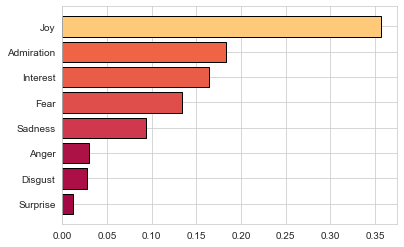

In [41]:
text = input()
plot_res(text, o=True)

아 왜이리 사기치는 기분같지...

Probability Distribution:
 [0.11308088 0.07300512 0.10584828 0.06074024 0.13585548 0.16245848
 0.27614576 0.07286576]

FEAR


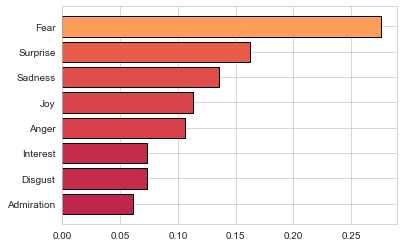

In [42]:
text = input()
plot_res(text, o=True)